# Python Learning Sessions: Feature Engineering

![impute](resources\sklearn.impute.png)

## Missing values

When dealing with missing values, there are a lot of strategies to deal with them:
* `Dropping the columns` - When there are a lot of missing values, it is better to drop the column.
* `Dropping the rows` - If dataset size is much larger than the rows with missing values, it is better to drop the rows. Be careful, however, as your model might encouter missing values at infernce and may pickup errors.
* `Imputation` - When the missing values are relatively small, imputation might improve the model's performance. There are a few ways to impute the missing values:
    * Last value carried forward - Commonly used in time series data.
    * Mean - Use the mean of the column to impute the missing values. Commonly used in regression.
    * Median - Use the median of the column to impute the missing values.
    * k-NN - Use the k-nearest neighbors to impute the missing values.
    * Using NA as a placeholder - Use NA as a placeholder for the missing values. Models will treat this as a different category.
    * Other logical rules - Use the logical rules to impute the missing values, e.g., 
* `Adding indicator variables` - Quite common in social sciences; adding an extra column that indicates if the value is missing or not.
* `Using a model has native support for missing values` - Use a model that can process missing value, e.g., `HistGradientBoostingClassifier` or `LightGBMClassifier`.
* `Random` - Use random values to impute the missing values.

You have to be careful when dealing with missing values. There are several mechanisms how missing values are generated (Gelman, 2007):
* `Completely random` - The missing values are generated completely randomly. Discarding these samples does not bias inference.
* `Missingness at random` - The missing values are not generated completely randomly. It may depend on different groups of samples. This can be ignored if they are related to a certain feature.
* `Missing values depend on external factors` - The missing values are generated based on external factors that are not caputred in the dataset. Recommended to model as a missing value.
* `Missng values that depend on the value of the feature` - The missing values are generated based on the value of the feature itself, e.g., people with low salary might not disclose it.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import set_config

set_config(display="diagram")

In [2]:
link = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/taxis.csv'
df = pd.read_csv(link, parse_dates=[0, 1])
df

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,Hudson Sq,Yorkville West,Manhattan,Manhattan
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,Midtown East,Yorkville West,Manhattan,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,East Harlem North,Central Harlem North,Manhattan,Manhattan
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,Jamaica,East Concourse/Concourse Village,Queens,Bronx
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,Crown Heights North,Bushwick North,Brooklyn,Brooklyn
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,East New York,East Flatbush/Remsen Village,Brooklyn,Brooklyn


In [67]:
def convert_text_cols_to_categorical(df):
    cols = df.select_dtypes(include=['object']).columns
    return df.astype({col: 'category' for col in cols})
    
X = df.pipe(convert_text_cols_to_categorical).drop(
    columns=['fare', 'tip', 'tolls', 'total'])
y = df['total']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6433 entries, 0 to 6432
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup           6433 non-null   datetime64[ns]
 1   dropoff          6433 non-null   datetime64[ns]
 2   passengers       6433 non-null   int64         
 3   distance         6433 non-null   float64       
 4   color            6433 non-null   category      
 5   payment          6389 non-null   category      
 6   pickup_zone      6407 non-null   category      
 7   dropoff_zone     6388 non-null   category      
 8   pickup_borough   6407 non-null   category      
 9   dropoff_borough  6388 non-null   category      
dtypes: category(6), datetime64[ns](2), float64(1), int64(1)
memory usage: 267.3 KB


### Using a model has native support for missing values

In [68]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.impute import SimpleImputer

preproc = ColumnTransformer(
    transformers=[
        ('date', 'drop', make_column_selector(dtype_include=['datetime64[ns]'])),
        (
            'categorical',
            OrdinalEncoder(
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            ) ,
            make_column_selector(dtype_include=['category']))
    ],
    remainder='passthrough',
)
preproc

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('variance', VarianceThreshold()),
        ('predictor', Lasso(alpha=0.8)),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190EE0>),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190A90>)])),
                ('variance', VarianceThreshold()),
                ('predictor', Lasso(alpha=0.8))])

In [69]:
pipe.fit(X, y)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [71]:
from sklearn.ensemble import HistGradientBoostingRegressor

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('variance', VarianceThreshold()),
        ('predictor', HistGradientBoostingRegressor()),
    ]
)
pipe.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190EE0>),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190A90>)])),
                ('variance', VarianceThreshold()),
                ('predictor', HistGradientBoostingRegressor())])

In [76]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipe, X=X,y=y, cv=5)
'CV Score:', scores.mean()

('CV Score:', 0.8329526438640601)

### Univariate feature imputation
Uses basic approach such as mean, median or mode to impute missing values.

In [77]:
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', SimpleImputer()),
        ('variance', VarianceThreshold()),
        ('predictor', RandomForestRegressor()),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190EE0>),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190A90>)])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('predictor', RandomForestRegressor())])

In [78]:
scores = cross_val_score(pipe, X=X,y=y, cv=5)
'CV Score:', scores.mean()

('CV Score:', 0.8120387683059794)

### Multivariate feature imputation
A more sophisticated approach is to use a model to impute missing values. At each iteration, one feature with missing values is selected and the model is trained on the complete dataset. to predict the missing values. A disadvantage of this approach is that it takes a long time to train.

In [87]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', IterativeImputer(estimator=BayesianRidge())),
        ('variance', VarianceThreshold()),
        ('predictor', RandomForestRegressor()),
    ]
)

In [88]:
scores = cross_val_score(pipe, X=X,y=y, cv=5)
'CV Score:', scores.mean()

('CV Score:', 0.8077764551425604)

### Marking imputed values
You can also mark the imputed values with another feature that indicates the missingness.

In [103]:
from sklearn.pipeline import FeatureUnion
from sklearn.impute import MissingIndicator

missing = FeatureUnion(
    transformer_list=[
        ('features', SimpleImputer()),
        ('indicators', MissingIndicator(sparse=False, error_on_new=False))
    ]
)

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', missing),
        ('variance', VarianceThreshold()),
        ('predictor', RandomForestRegressor()),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190EE0>),
                                                 ('categorical',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0190A90>)])),
                ('imputer',
                 FeatureUnion(transformer_list=[('features', SimpleImputer()),
                                                ('indicators',
                                                 MissingIndicator(error_on_new=False,
                                                                  sparse=False))])),
                ('variance', VarianceThreshold()),
                ('predictor', RandomForestRegressor())])

In [105]:
scores = cross_val_score(pipe, X=X,y=y, cv=5)
'CV Score:', scores.mean()

('CV Score:', 0.8280057321569227)

## Preprocessing data

### Encoding categorical features
For linear models, categorical features are typically encoded using one-hot encoding. For example, if you have a categorical feature with 3 categories, you will have 3 columns in the resulting dataset. You can also use an ordinal encoding, which is similar to one-hot encoding, but uses integers instead of binary values. This works for tree-based models such as random forests and gradient boosting but may not make sense for linear.

In [107]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

preproc = ColumnTransformer(
    transformers=[
        ('date', 'drop', make_column_selector(dtype_include=['datetime64[ns]'])),
        (
            'categorical',
            OneHotEncoder(
                handle_unknown='ignore',
            ) ,
            make_column_selector(dtype_include=['category']))
    ],
    remainder='passthrough',
)

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', SimpleImputer()),
        ('variance', VarianceThreshold()),
        ('predictor', Lasso(alpha=0.8)),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0ADADF0>),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C0ADADC0>)])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('predictor', Lasso(alpha=0.8))])

In [108]:
scores = cross_val_score(pipe, X=X,y=y, cv=5)
'CV Score:', scores.mean()

('CV Score:', 0.8125720208777597)

### Standardization, or mean removal and variance scaling
When using linear models such as logistic regression, or SVMs, we may need to scale the data in order to remove bias to features with different magnitudes. This help in explainability as the feature importance will be on the same scale. This will also put variances at the same scales, therefore reducing mistakes when selecting features based on variances.
This may also apply to non-linear models such as neural networks.

In [126]:
from sklearn.preprocessing import MinMaxScaler

preproc = ColumnTransformer(
    transformers=[
        ('date', 'drop', make_column_selector(dtype_include=['datetime64[ns]'])),
        ('categorical', OneHotEncoder(handle_unknown='ignore'),
         make_column_selector(dtype_include=['category'])),
        ('numerical', StandardScaler(), ['passengers', 'distance'])
    ],
    remainder='passthrough',
)

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', SimpleImputer()),
        ('variance', VarianceThreshold()),
        ('predictor', Lasso(alpha=0.8)),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C1D662E0>),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C1D66A60>),
                                                 ('numerical', StandardScaler(),
                                                  ['passengers',
                                                   'distance'])])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('predictor', Lasso(alpha=0.8))])

In [127]:
scores = cross_val_score(pipe, X=X,y=y, cv=5, error_score='raise')
'CV Score:', scores.mean()

('CV Score:', 0.809588991307673)

### Non-linear transformation
We can also "scale" the feature to a given distribution. For example, we can map the feature to a uniform distribution.

<AxesSubplot:ylabel='Density'>

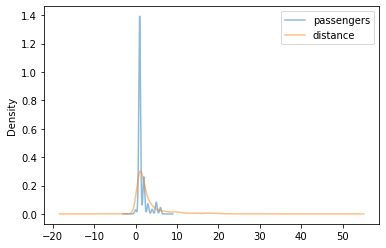

In [136]:
X[['passengers', 'distance']].plot(kind='kde', alpha=0.5)

In [151]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

preproc = ColumnTransformer(
    transformers=[
        ('date', 'drop', make_column_selector(dtype_include=['datetime64[ns]'])),
        ('categorical', OneHotEncoder(handle_unknown='ignore'),
         make_column_selector(dtype_include=['category'])),
        ('numerical', PowerTransformer(), ['distance'])
    ],
    remainder='passthrough',
)

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', SimpleImputer()),
        ('variance', VarianceThreshold()),
        ('predictor', Lasso(alpha=0.8)),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C92BEF40>),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C9290790>),
                                                 ('numerical',
                                                  PowerTransformer(),
                                                  ['distance'])])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('predictor', Lasso(alpha=0.8))])

In [152]:
scores = cross_val_score(pipe, X=X,y=y, cv=5, error_score='raise')
'CV Score:', scores.mean()

('CV Score:', 0.5034034161590429)

### Discretization

In [153]:
from sklearn.preprocessing import KBinsDiscretizer

preproc = ColumnTransformer(
    transformers=[
        ('date', 'drop', make_column_selector(dtype_include=['datetime64[ns]'])),
        ('categorical', OneHotEncoder(handle_unknown='ignore'),
         make_column_selector(dtype_include=['category'])),
        ('numerical', KBinsDiscretizer(n_bins=10), ['distance'])
    ],
    remainder='passthrough',
)

pipe = Pipeline(
    steps=[
        ('preprocess', preproc),
        ('imputer', SimpleImputer()),
        ('variance', VarianceThreshold()),
        ('predictor', Lasso(alpha=0.8)),
    ]
)
pipe

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('date', 'drop',
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C92F2910>),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B6C92CB790>),
                                                 ('numerical',
                                                  KBinsDiscretizer(n_bins=10),
                                                  ['distance'])])),
                ('imputer', SimpleImputer()), ('variance', VarianceThreshold()),
                ('predictor', Lasso(alpha=0.8))])

In [154]:
scores = cross_val_score(pipe, X=X,y=y, cv=5, error_score='raise')
'CV Score:', scores.mean()

('CV Score:', 0.5699675671995863)

### Polynomial features

In [155]:
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.datasets import fetch_openml
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate


bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame

y = df["count"] / df["count"].max()
X = df.drop("count", axis="columns")
categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)
alphas = np.logspace(-6, 6, 25)

def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.098 +/- 0.012
Root Mean Squared Error: 0.132 +/- 0.013


## References
* [6.3. Preprocessing data](https://scikit-learn.org/stable/modules/preprocessing.html)
* [6.4. Imputation of missing values](https://scikit-learn.org/stable/modules/impute.html)
* Gelman, Andrew, and Jennifer Hill. Data Analysis Using Regression and Multilevel/hierarchical Models. Cambridge: Cambridge University Press, 2007